In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
import matplotlib.image as mpimg
from matplotlib.widgets import PolygonSelector
from PIL import Image

plt.style.use('default')

Task1

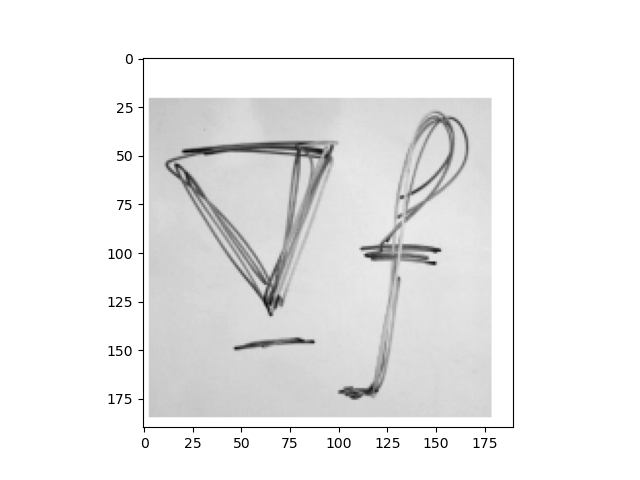

Polygon vertices:
[(38.363485757406636, 11.837662729866068), (26.539892683813576, 170.68506532726866), (179.73253337645428, 137.2705631627665), (148.37430826822916, 21.090909483112824)]


In [2]:
#source_img_path = "InputImgs\\SrcImg.png"
#target_img_path = "InputImgs\\DstImg.png"
source_img_path = "InputImgs\\1.png"
target_img_path = "InputImgs\\2.png"
source_img_grey = cv2.imread(source_img_path, cv2.IMREAD_GRAYSCALE)
target_img_grey = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
target_img_ = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)


img_array = source_img_grey.copy()

def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)

# plot
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# use PolygonSelector to select our polygon
polygon_selector = PolygonSelector(ax, onselect)

# plot image for polygon selection 
plt.show()

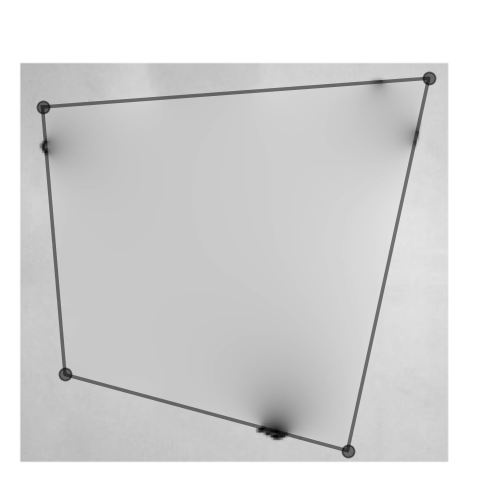

In [3]:
if  0 == polygon.count:
    polygon = [(23., 13.), (24., 169.), (176., 131.), (170., 22.)]
    print("Using the default polygon, you could also choose a specific polygen by running the cell above and click on the img showed")

%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import polygon2mask
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
from skimage.color import rgb2gray

gray_image = source_img_grey.copy()  # 转换为灰度图像

# 获取图像尺寸
image_height, image_width = gray_image.shape[:2]
# 创建多边形掩码
mask = polygon2mask((image_height, image_width), polygon)

# 获取多边形内部的像素索引
interior_idx = np.argwhere(mask)

# 初始化稀疏矩阵A和向量b
n_interior_pixels = len(interior_idx)
A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
b = np.zeros(n_interior_pixels)

# 构建线性系统
for i, (row, col) in enumerate(interior_idx):
    A[i, i] = 4  # 主对角线元素
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 四个方向的邻居
        neighbor = (row + drow, col + dcol)
        if mask[neighbor]:  # 如果邻居在内部
            j = np.argwhere(np.all(interior_idx == neighbor, axis=1))[0, 0]
            A[i, j] = -1
        else:
            # 如果邻居在边界上或者在掩码外面，我们需要从源图像中获取对应的强度值
            b[i] += gray_image[neighbor]

# 将A矩阵转换为CSR格式
A_csr = A.tocsr()

# 求解线性系统
solution = spsolve(A_csr, b)

# 将解填充回图像的相应区域
for (solution_value, (row, col)) in zip(solution, interior_idx):
    # print(row, col)
    gray_image[row, col] = solution_value

# 显示填充后的图像
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
kx_forward = np.array([
    [0, 0, 0],
    [0, -1, 1],
    [0, 0, 0]
])
ky_forward = np.array([
    [0, 0, 0],
    [0, -1, 0],
    [0, 1, 0]
])

# For backward condition
kx_backward = np.array([
    [0, 0, 0],
    [1, -1, 0],
    [0, 0, 0]
])
ky_backward = np.array([
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 0]
])

# Combine into an array of length 4
combined_matrices = np.array([kx_forward, ky_forward, kx_backward, ky_backward])

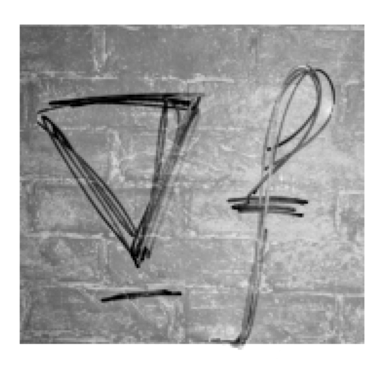

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [8]:
from scipy import signal

source_img = Image.open(source_img_path).convert('L')
target_img = Image.open(target_img_path).convert('L')
source_img_array = np.array(source_img, dtype=np.uint8)
target_img_array = np.array(target_img, dtype=np.uint8)

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, polygon, mode='importing'):
    # 创建拉普拉斯算子
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    # 计算源图像的拉普拉斯算子
    grad_source = signal.convolve2d(source_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    grad_target = signal.convolve2d(target_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    # 获取掩码内的索引
    idx = np.argwhere(mask)
    
    # 创建系数矩阵A和向量b
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)
    grads = []
    for i in range(4):
        srcGrad = signal.convolve2d(source_img, combined_matrices[i], mode='same', boundary='fill', fillvalue=0)
        dstGrad = signal.convolve2d(target_img, combined_matrices[i], mode='same', boundary='fill', fillvalue=0)
        grads.append(np.where(np.abs(srcGrad) > np.abs(dstGrad), srcGrad, dstGrad))

    # 这里是和而不是选最大应该是因为虽然公式说是相等，但这个等式两边都是一阶导数，而你下面还是写的二阶导数，所以这里为了配合A，也要
    # 通过累加和A对应
    divergence = np.sum(grads, axis=0) # 四个梯度求和，即两个散度求和，得到最终的散度
    
    for i, (row, col) in enumerate(idx):
        A[i, i] = 4
        if mode == 'importing':
                b[i] -= grad_source[row, col]
        elif mode == 'mixing':
            b[i] -= divergence[row, col]
        for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (row + drow, col + dcol)
            if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                if mask[neighbor]:
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    if j.size > 0:
                        A[i, j[0][0]] = -1
                else:
                    b[i] += target_img[neighbor]
    
    
    # 解线性方程组
    solution = spsolve(A.tocsr(), b)
    #solution = np.round(solution).astype(np.uint8)

    # 创建一个新的目标图像以填充结果
    cloned_img = target_img.copy()
    for (row, col), value in zip(idx, solution):
        cloned_img[row, col] = np.clip(value, 0, 255)

    plt.imshow(cloned_img, cmap='gray')
    plt.axis('off')
    plt.show()
    return cloned_img

# 使用导入梯度
#seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='importing')
seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='mixing')

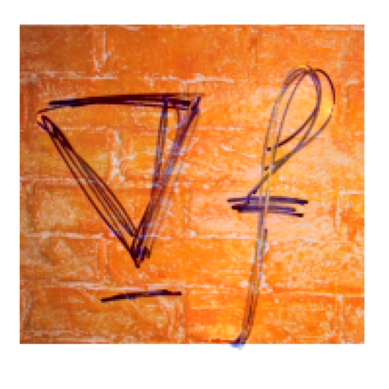

In [9]:
from PIL import Image
from scipy import signal, sparse
import numpy as np
import os
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt


def seamless_cloning(source_img, target_img, mask, mode='importing'):
    cloned_img = np.empty_like(target_img)
    for channel in range(3):
        source_channel = source_img[:,:,channel]
        target_channel = target_img[:,:,channel]

        # Compute Laplacian
        laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)
        grad_target = signal.convolve2d(target_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

        # Get mask indices
        idx = np.argwhere(mask)

        # Create coefficient matrix A and vector b
        n_pixels = len(idx)
        A = sparse.lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)
        grads = []
        
        kernel = [
            np.array([[0, -1, 1]]),  # Horizontal edge detection (left to right)
            np.array([[1, -1, 0]]),  # Horizontal edge detection (right to left)
            np.array([[0], [-1], [1]]),  # Vertical edge detection (top to bottom)
            np.array([[1], [-1], [0]])   # Vertical edge detection (bottom to top)
        ]
        

        for i in range(4):
            #srcGrad = cv2.filter2D(np.float64(source_channel), -1, kernel[i])
            #dstGrad = cv2.filter2D(np.float64(target_channel), -1, kernel[i])
 
            srcGrad = signal.convolve2d(source_channel, combined_matrices[i], mode='same', boundary='fill', fillvalue=0)
            dstGrad = signal.convolve2d(target_channel, combined_matrices[i], mode='same', boundary='fill', fillvalue=0)
            
            grads.append(np.where(np.abs(srcGrad) > np.abs(dstGrad), srcGrad, dstGrad)) # 哪个梯度大就取哪个

        # 这里是和而不是选最大应该是因为虽然公式说是相等，但这个等式两边都是一阶导数，而你下面还是写的二阶导数，所以这里为了配合A，也要
        # 通过累加和A对应
        divergence = np.sum(grads, axis=0) # 四个梯度求和，即两个散度求和，得到最终的散度
        
        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            if mode == 'importing':
                b[i] -= grad_source[row, col]
            elif mode == 'mixing':
                #b[i] -= calcMixDiv(source_channel, target_channel, row, col)
                b[i] -= divergence[row, col]
                # 求src图、dst梯度
                
                # # 使用源图像和目标图像的最大梯度
                # if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                #         b[i] -= grad_source[row, col]
                # else:
                #     b[i] -= grad_target[row, col]
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            A[i, j[0][0]] = -1
                    else:
                        b[i] += target_channel[neighbor]

        # Solve linear system
        solution = spsolve(A.tocsr(), b)

        # Fill in the cloned image
        channel_cloned = target_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_cloned[row, col] = np.clip(value, 0, 255)
        cloned_img[:,:,channel] = channel_cloned

    return cloned_img

source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)


# 使用导入梯度
#result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='importing')
result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing')

# 展示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

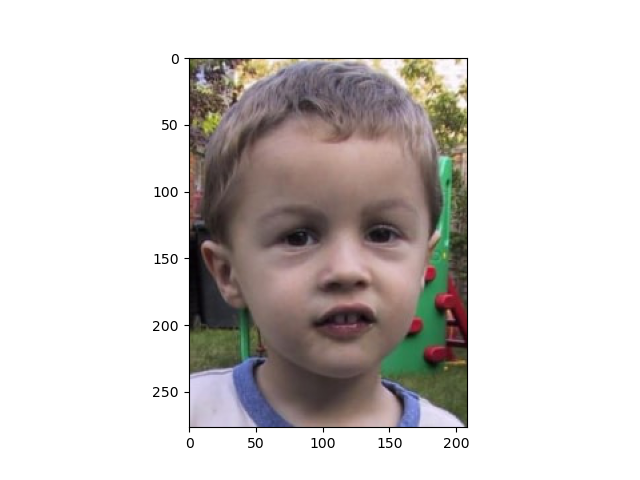

Polygon vertices:
[(95.88055763409767, 53.93614489898022), (95.1310987596388, 168.603352691188), (131.85458360812365, 179.09577693361226), (222.53910741764744, 137.12607996391526), (218.79181304535308, 82.41558212841744), (128.85674811028815, 42.6942617820971)]


In [10]:
%matplotlib widget
# 应用纹理平坦化
img_path = "InputImgs//qwe.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_array = image.copy()

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon_flatten
    polygon_flatten = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon_flatten)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

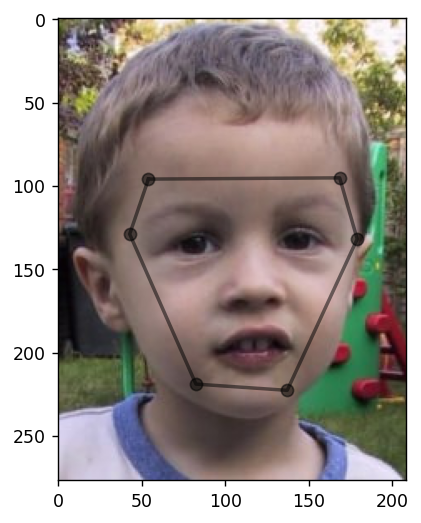

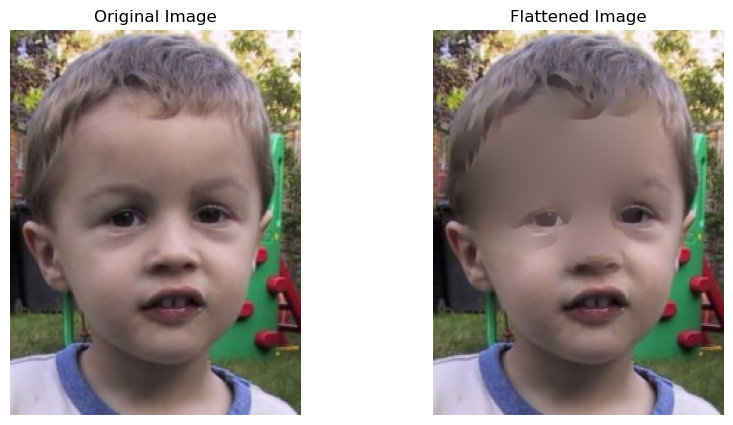

In [11]:
if  0 == polygon_flatten.count:
    polygon_flatten = [(91., 56.), (93., 166.), (135., 179.), (220., 133.), (214., 70.)]
    print("Using the default polygon, you could also choose a specific polygen by running the cell above and click on the img showed")

%matplotlib inline
import numpy as np
import cv2
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d

def texture_flattening(source_img, mask, strength=1.):
    flattened_img = np.empty_like(source_img)
    mask = mask.astype(bool)  # 确保掩码是布尔类型

    for channel in range(3):  # 对于RGB的每个通道
        source_channel = source_img[:, :, channel]

        laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

         # 用于计算src四个方向梯度的核
        kernel = [np.array([[0, -1, 1]]), np.array([[1, -1, 0]]),
                np.array([[0], [-1], [1]]), np.array([[1], [-1], [0]])]
        # 用于检测四个方向边缘点的核
        kernelEdge = [np.array([[0, 1, 1]]), np.array([[1, 1, 0]]),
                        np.array([[0], [1], [1]]), np.array([[1], [1], [0]])]
        # 1. canny检测边缘
        canny = cv2.Canny(source_channel, 80, 120)
        # 2. 检测四个方向边缘点
        edges = [cv2.filter2D(canny, -1, kernelEdge[i]) for i in range(4)]
        # 3. 计算src四个方向梯度
        grads = [cv2.filter2D(np.float64(source_channel), -1, kernel[i]) for i in range(4)]
        # 4. 不是边缘点的将梯度修改为0
        for i in range(4):
            for j in range(edges[i].shape[0]):
                for k in range(edges[i].shape[1]):
                    if edges[i][j][k] == 0:
                        grads[i][j][k] = 0
        # 5. 计算src的散度
        laplacian = np.sum(grads, axis=0)

        # 建立方程组的A矩阵和b向量
        idx = np.argwhere(mask)
        n_pixels = len(idx)
        A = lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            b[i] -= laplacian[row, col] # Subtracts the gradient to remove the texture
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            A[i, j[0][0]] = -1
                    else:
                        b[i] += source_channel[neighbor]

        # 解决线性系统
        solution = spsolve(A.tocsr(), b)

        # 填充平坦化的图像
        channel_flattened = source_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_flattened[row, col] = np.clip(value, 0, 255)
        flattened_img[:, :, channel] = channel_flattened

    return flattened_img

# 应用纹理平坦化
img_path = "InputImgs//qwe.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width = image.shape[:2]
mask = polygon2mask((image_height, image_width), polygon)
flat_img = texture_flattening(image, mask)

# 展示原始图像和平坦化后的图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(flat_img)
axes[1].set_title('Flattened Image')
axes[1].axis('off')

plt.show()
